In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
series = pd.read_csv('datasets/series.csv', encoding= 'unicode_escape')
train = pd.read_csv('datasets/observations_train.csv')
test = pd.read_csv('datasets/observations_test.csv')

In [3]:
# correct datatype
train.date = pd.to_datetime(train.date)
test.date = pd.to_datetime(test.date)

In [4]:
# include sp500 which has 'Daily, Close'
daily_id = series[(series.frequency == 'Daily') | (series.frequency == 'Daily, 7-Day') |\
                  (series.frequency == 'Daily, Close')]['ï»¿series_id']
weekly_id = series[(series.frequency == 'Weekly, Ending Saturday') | (series.frequency == 'Weekly, Ending Thursday') |\
                   (series.frequency == 'Weekly, Ending Wednesday')]['ï»¿series_id']
monthly_id = series[(series.frequency == 'Monthly')]['ï»¿series_id']

In [5]:
# separate data and exclude weekends
train_daily = train[train['series_id'].isin(daily_id)]
train_weekly = train[train['series_id'].isin(weekly_id)]
train_monthly = train[train['series_id'].isin(monthly_id)]
train_daily = train_daily[train_daily['date'].dt.dayofweek < 5]

test_daily = test[test['series_id'].isin(daily_id)]
test_weekly = test[test['series_id'].isin(weekly_id)]
test_monthly = test[test['series_id'].isin(monthly_id)]
test_daily = test_daily[test_daily['date'].dt.dayofweek < 5]

In [6]:
# set index for date
for df in [train_daily, train_weekly, train_monthly, test_daily, test_weekly, test_monthly]:
    df.set_index('date', inplace=True)

In [7]:
# a total of 1 na in train ser after interpolation
train_daily = train_daily.groupby('series_id').apply(lambda group: group.interpolate('time')).dropna()
train_weekly = train_weekly.groupby('series_id').apply(lambda group: group.interpolate('time'))
train_monthly = train_monthly.groupby('series_id').apply(lambda group: group.interpolate('time'))

# a total of 0 na in train ser after interpolation
test_daily = test_daily.groupby('series_id').apply(lambda group: group.interpolate('time'))
test_weekly = test_weekly.groupby('series_id').apply(lambda group: group.interpolate('time'))
test_monthly = test_monthly.groupby('series_id').apply(lambda group: group.interpolate('time'))

In [8]:
daily = pd.concat([train_daily, test_daily])
weekly = pd.concat([train_weekly, test_weekly])
monthly = pd.concat([train_monthly, test_monthly])

In [9]:
# return normalized dataset and stats to unnormalize
def in_group_norm(df):
    stats = pd.DataFrame()
    stats['series_id'] = df.series_id.unique().tolist()
    stats['mean'] = df.groupby('series_id').mean().value.tolist()
    stats['std'] = df.groupby('series_id').std().value.tolist()
    df.value = df.groupby('series_id').transform(lambda x: (x - x.mean()) / x.std()).value
    return df, stats

In [10]:
daily, daily_stats = in_group_norm(daily)
weekly, weekly_stats = in_group_norm(weekly)
monthly, monthly_stats = in_group_norm(monthly)

In [11]:
train_daily, train_daily_stats = in_group_norm(train_daily)
train_weekly, train_weekly_stats = in_group_norm(train_weekly)
train_monthly, train_monthly_stats = in_group_norm(train_monthly)

In [12]:
# normalize the data
train_daily, train_daily_stats = in_group_norm(train_daily)
train_weekly, train_weekly_stats = in_group_norm(train_weekly)
train_monthly, train_monthly_stats = in_group_norm(train_monthly)

test_daily, test_daily_stats = in_group_norm(test_daily)
test_weekly, test_weekly_stats = in_group_norm(test_weekly)
test_monthly, test_monthly_stats = in_group_norm(test_monthly)

In [13]:
# concat back to train and test set
train_cleaned = pd.concat([train_daily, train_weekly, train_monthly])
test_cleaned = pd.concat([test_daily, test_weekly, test_monthly])

train_cleaned.to_csv('datasets/train_cleaned.csv')
test_cleaned.to_csv('datasets/test_cleaned.csv')

In [14]:
pd.concat([daily, weekly, monthly]).to_csv('datasets/viz_eda.csv')

In [16]:
daily

,series_id,value
date,,
2000-01-03,AAA10Y,-0.925802
2000-01-04,AAA10Y,-0.856570
2000-01-05,AAA10Y,-0.948880
2000-01-06,AAA10Y,-0.971957
2000-01-07,AAA10Y,-0.925802
...,...,...
2020-06-08,WLEMUINDXD,1.565988
2020-06-09,WLEMUINDXD,1.171551
2020-06-10,WLEMUINDXD,0.366100


In [17]:
df1 = pd.read_csv('datasets/train_cleaned.csv')
df2 = pd.read_csv('datasets/test_cleaned.csv')
df = pd.concat([df1, df2])
df.to_csv('all.csv')

In [18]:
df

,date,series_id,value
0,2000-01-03,AAA10Y,-1.036107
1,2000-01-04,AAA10Y,-0.967114
2,2000-01-05,AAA10Y,-1.059104
3,2000-01-06,AAA10Y,-1.082102
4,2000-01-07,AAA10Y,-1.036107
...,...,...,...
22877,2019-12-01,UNRATE,-0.320679
22878,2020-01-01,UNRATE,-0.273366
22879,2020-02-01,UNRATE,-0.320679
22880,2020-03-01,UNRATE,0.105141


<AxesSubplot:xlabel='series_id', ylabel='value'>

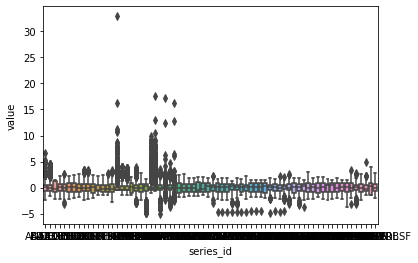

In [6]:
sns.boxplot(x="series_id", y="value", data=df)